The model we are hoping to build looks like: 

V_ij = eps_ij $*$ (V_ii $*$ e^(-i $*$ pi $*$ tau_ci $*$ nu) + V_jj $*$ e^(-i $*$ pi $*$  tau_cj $*$ nu)) 
        + P_ij * e^(-i * pi * tau_aij * nu) * (V_ii + V_jj)

The variables we are working with are: 

V_ij : the data averaged across time

        (getting the approx from: the data array for the combined and averaged uvfits files)

eps_ij : the amplitude of the signal traveling through cables

        (getting the approx from: the amplitude array from outside baseline dependence; shape is Nbls by Nfreqs)

V_ii, V_jj : the autocorrelation for each of the two antennas

P_ij : the amplitude of the signal traveling through the air

        (getting the approx from: the amplitude array within baseline dependence; shape is Nbls by Nfreqs)

tau_ci, tau_cj : the "cable" delays 

        (getting the approx from: a row or column of amplitude array averaged across frequency)

tau_aij : the air delay 
        
        (getting the approx from: baseline length in ns)

nu : the frequency

        (getting the approx from: the frequency array)

In [851]:
#Initialize matplotlib notebook
%matplotlib notebook
#Import needed packages
from pyuvdata import UVData
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import cmath

#Create uv elements
uvxy = UVData()
uvyx = UVData()
uvxx = UVData()
uvyy = UVData()

#Create constant variables
#Variable for the speed of light
c = 0.299792 #* 1e10
#Variable for speed of light in a cable correction factor, based on Google search
f = .83

#Create an array of antennas we want to flag
flagged_antennas = np.array([0,2,26,50,98,136])

In [904]:
#Define antenna numbers

antenna1 = 1
antenna2 = 25

In [905]:
#Read each of the data files into the uv objects

# Read in the xy data file
uvxy.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xy_time_split_data/combined_files/zen.grp1.of1.xy.LST.run_7.uvOCRSL.uvfits')

# Read in the yx data file
uvyx.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/yx_time_split_data/combined_files/zen.grp1.of1.yx.LST.run_8.uvOCRSL.uvfits')

#Read in the xx data file
uvxx.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xx_time_split_data/combined_files/zen.grp1.of1.xx.LST.run_2.uvOCRSL.uvfits')

#Read in the yy data file
uvyy.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_yy_time_split_data/combined_files/zen.grp1.of1.yy.LST.run_2.uvOCRSL.uvfits')

In [906]:
#Check shapes
print 'Frequency array shape:', uvxy.freq_array.shape
print 'Data array shape:', uvxy.data_array.shape
print 'Nbls:', uvxy.Nbls
print 'Nfreqs:', uvxy.Nfreqs

Frequency array shape: (1, 1024)
Data array shape: (1378, 1, 1024, 1)
Nbls: 1378
Nfreqs: 1024


Our arrays need to be Nbls by Nfreqs, or (1378,1024). 

We will need to create an array of zeros of the desired size and then extract the information from the file's original arrays. For instance, to create a data array of the correct size, we will need to create an array of zeros of size (1378,1024), and then equate the first dimension with the first dimension of the data array, and then the second dimenstion with the third dimension of the data array. 

In [907]:
#Read in the position and antenna numbers for all antennas
#These will be passed into functions to plot the antennas in the correct positions
antpos, ants = uvxy.get_ENU_antpos()

In [908]:
def find_bl_len(antnum1,antnum2):
    blin_length = 0
    #Step through each antenna pair with the entered antenna
    for aa,ant1 in enumerate(ants):
        for bb,ant2 in enumerate(ants):
            if (ant1 == antnum1 or ant1 == antnum2) and (ant2==antnum1 or ant2==antnum2):
                #Find the horizontal distance between the two antennas
                x = antpos[aa,0] - antpos[bb,0]
                #Find the vertical distance between the two antennas
                y = antpos[aa,1] - antpos[bb,1]
                #Find the hypotenus of the triangle, which is the total distance between
                #the two antennas
                diag = np.sqrt(x**2 + y**2)
                #Place this value into the array
                if diag != 0:
                    blin_length = diag
    return(blin_length)

In [909]:
#Create arrays of desired size
xy_data_array = np.zeros([uvxy.Nbls,uvxy.Nfreqs])
xy_freq_array = np.zeros([uvxy.Nbls,uvxy.Nfreqs])

#Check the sizes of the arrays in the uv object
print 'UVXY data array shape:', uvxy.data_array.shape
#This isolates the two dimensions we want
print 'UVXY data array selected dims shape:', uvxy.data_array[:,0,:,0,].shape
print 'UVXY frequency array shape:', uvxy.freq_array.shape

#test = np.array([[1,2,7],[3,4,8],[5,6,9]])
#print test[:,1] #this is the way to look at a specific column
#print test[2,:] #this is the way to look at a specific row

#Equate the frequency arrays while maintaining the corrected size
xy_freq_array[0:1] = uvxy.freq_array
print 'XY frequency array shape:', xy_freq_array.shape
print 'XY frequency array mean:', np.mean(xy_freq_array[0:1])
print 'UVXY frequency array mean:', np.mean(uvxy.freq_array)

#Equate the data arrays while maintaining the desired size
xy_data_array = uvxy.data_array[:,0,:,0,]
print 'XY data array shape:', xy_data_array.shape
print 'XY data array mean:', np.mean(xy_data_array)
print 'UVXY data array mean:', np.mean(uvxy.data_array)

UVXY data array shape: (1378, 1, 1024, 1)
UVXY data array selected dims shape: (1378, 1024)
UVXY frequency array shape: (1, 1024)
XY frequency array shape: (1378, 1024)
XY frequency array mean: 149951171.875
UVXY frequency array mean: 149951171.875
XY data array shape: (1378, 1024)
XY data array mean: (0.0033089141+0.0070777163j)
UVXY data array mean: (0.0033089141+0.0070777163j)


In [910]:
#Create the arrays to be returned
blin_amp = np.zeros([uvxy.Nbls,uvxy.Nfreqs])
delays = np.zeros([uvxy.Nbls,uvxy.Nfreqs])

#Define constants for the beginning element that is within baseline 
#depenedence and the end element
blin_start = 471
blin_end = 554


for i,ant1 in enumerate(uvxy.ant_2_array):
    #Get the second antenna number using the index number
    ant2 = uvxy.ant_1_array[i]

    #Flag out dead antennas
    if np.any(ant1==flagged_antennas):
        blin_amp[i] = 0
        delays[i] = 0
        continue
    
    if np.any(ant2==flagged_antennas):
        blin_amp[i] = 0
        delays[i] = 0
        continue
        
    if (ant1==antenna1 and ant2==antenna2) or (ant1==antenna2 and ant2==antenna1):
        # Create an array to hold the night's data
        spectrum = uvxy.data_array[i,0,:,0]
        print 'spectrum shape:', spectrum.shape
        print 'spectrum mean:', np.mean(spectrum)
        # Fourier transform along the time axis
        vis_avg_delay = np.fft.fftshift(np.fft.fft(spectrum))
        print 'vis_avg_delay shape:', vis_avg_delay.shape
        #Find the frequency width of a channel in GHz
        freq_width = np.diff(uvxy.freq_array[0,:])[0]
        #Convert frequencies to delays and convert to ns
        con_delays = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs, freq_width))*1e9
        # Find the maximum amplitude and put into a variable
        blin_peak = np.max(np.abs(vis_avg_delay[blin_start:blin_end]))
        #If the peak is zero, meaning there is no peak, the delay is set to zero
        if blin_peak==0:
            blin_delay = 0
        else:
            #Find the corresponding delay
            blin_delay = con_delays[np.argwhere(np.abs(vis_avg_delay)==blin_peak)]
        # Append the maximum amplitude array with a list of the antenna pair and
        #the peak
        blin_amp[i] = blin_peak
        #Append the delay array with a list of the antenna pair and the delay
        delays[i] = blin_delay
    else: 
        blin_amp[i] = 0
        delays[i] = 0

#Convert to numpy arrays

print 'Baseline amplitude array shape:', blin_amp.shape
print 'Baseline amplitude array mean:', np.mean(blin_amp)
print 'Baseline delay array shape:', delays.shape
print 'Baseline delay array mean:', np.mean(delays)

spectrum shape: (1024,)
spectrum mean: (-0.0080293305+0.033675894j)
vis_avg_delay shape: (1024,)
Baseline amplitude array shape: (1378, 1024)
Baseline amplitude array mean: 0.04708575510321231
Baseline delay array shape: (1378, 1024)
Baseline delay array mean: 0.05805515239477504


In [911]:
#Define variables for the model equation

#The amplitude within baseline dependence
P_ij = blin_amp
print 'P_ij (baseline amplitude array) shape:', P_ij.shape

#The frequency array
nu = xy_freq_array
print 'Nu (frequency array) shape:', nu.shape

#Find the length of the baseline
tau_aij = find_bl_len(antenna1,antenna2)

#Convert meters to ns
tau_aij = tau_aij / c
print 'Tau_aij (m):', tau_aij

#Get the autocorr data for the antennas
V_ii = uvxy.get_data(antenna1,antenna1)
print 'V_ii (autocorr for first antenna) shape:', V_ii.shape
V_jj = uvxy.get_data(antenna2,antenna2)
print 'V_jj (autocorr for second antenna) shape:', V_jj.shape

#Get the data
V_ij = uvxy.get_data(antenna1,antenna2)
print 'V_ij (data for the two antennas) shape:', V_ij.shape

P_ij (baseline amplitude array) shape: (1378, 1024)
Nu (frequency array) shape: (1378, 1024)
Tau_aij (m): 84.40449859224003
V_ii (autocorr for first antenna) shape: (1, 1024)
V_jj (autocorr for second antenna) shape: (1, 1024)
V_ij (data for the two antennas) shape: (1, 1024)


In [912]:
#Create the arrays to be returned
ind_amp = np.zeros([uvxy.Nbls,uvxy.Nfreqs])
ind_delays = np.zeros([uvxy.Nbls,uvxy.Nfreqs])

#Define constants for the beginning element that is within baseline 
#depenedence and the end element
blin_start = 471
blin_end = 554

for i,ant1 in enumerate(uvxy.ant_2_array):
    #Get the second antenna number using the index number
    ant2 = uvxy.ant_1_array[i]

    #Flag out dead antennas
    if np.any(ant1==flagged_antennas):
        ind_amp[i] = 0
        ind_delays[i] = 0
        continue

    if np.any(ant2==flagged_antennas):
        ind_amp[i] = 0
        ind_delays[i] = 0
        continue

    if (ant1==antenna1 and ant2==antenna2) or (ant1==antenna2 and ant2==antenna1):
        # Create an array to hold the night's data
        spectrum = uvxy.data_array[i,0,:,0]
        print 'spectrum shape:', spectrum.shape
        print 'spectrum mean:', np.mean(spectrum)
        # Fourier transform along the time axis
        vis_avg_delay = np.fft.fftshift(np.fft.fft(spectrum))
        print 'vis_avg_delay shape:', vis_avg_delay.shape
        #Find the frequency width of a channel in GHz
        freq_width = np.diff(uvxy.freq_array[0,:])[0]
        #Convert frequencies to delays and convert to ns
        con_delays = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs, freq_width))*1e9
        # Find the maximum amplitude and put into a variable
        peak_below_bl = np.max(np.abs(vis_avg_delay[:blin_start]))
        peak_above_bl = np.max(np.abs(vis_avg_delay[blin_end:]))
        #If the peak is zero, meaning there is no peak, the delay is set to zero
        if peak_below_bl >= peak_above_bl:
            peak_amp = peak_below_bl
        else: 
            peak_amp = peak_above_bl
        if peak_amp == 0: 
            delay = 0
        else:
            #Find the corresponding delay
            delay = con_delays[np.argwhere(np.abs(vis_avg_delay)==peak_amp)]
        # Append the maximum amplitude array with a list of the antenna pair and
        #the peak
        ind_amp[i] = peak_amp
        #Append the delay array with a list of the antenna pair and the delay
        ind_delays[i] = delay
    else: 
        ind_amp[i] = 0
        ind_delays[i] = 0

#Convert to numpy arrays
print 'Baseline independent amplitude array shape:', ind_amp.shape
print 'Baseline independent amplitude array mean:', np.mean(ind_amp)
print 'Baseline independent delay array shape:', ind_delays.shape
print 'Baseline independent delay array mean:', np.mean(ind_delays)

spectrum shape: (1024,)
spectrum mean: (-0.0080293305+0.033675894j)
vis_avg_delay shape: (1024,)
Baseline independent amplitude array shape: (1378, 1024)
Baseline independent amplitude array mean: 0.008363080820601287
Baseline independent delay array shape: (1378, 1024)
Baseline independent delay array mean: -0.7910014513788098


In [913]:
#Define tau_ci and tau_cj
amplitude = []
i = 0
for amp in ind_amp:
    if np.any(amp!=0):
        amplitude = amp
        print 'Amplitude shape:', amplitude.shape
        print 'Row number', i
    i += 1
        
#Define the cable tau variables 
tau_ci = np.sum(amplitude,axis=0)
tau_ci /= (c * f)
print 'Tau ci:', tau_ci
tau_cj = np.sum(index,axis=0)
tau_cj /= (c * f)
print 'Tau cj:', tau_cj

Amplitude shape: (1024,)
Row number 60
Tau ci: 47426.09164718663
Tau cj: 72880.74996807023


In [914]:
#Define baseline independent amplitude array variable
eps_ij = ind_amp
print 'Eps ij (the baseline independent amplitude array) shape:', eps_ij.shape
print 'Eps ij (the baseline independent amplitude array) mean:', np.mean(eps_ij)


Eps ij (the baseline independent amplitude array) shape: (1378, 1024)
Eps ij (the baseline independent amplitude array) mean: 0.008363080820601287


In [915]:
#model equation

#The portion to model the signal traveling through the air
air_model = P_ij * (np.e**((-1j) * np.pi * tau_aij * nu)) * (V_ii + V_jj)
#The portion to model the signal traveling through cables/not baseline dependent amplitudes
cable_model = eps_ij * (V_ii * np.e**((-1j) * np.pi * tau_ci * nu) + V_jj * np.e**((-1j) * np.pi * tau_cj * nu))

#Add the two pieces together to form the model equation
model = V_ij - (air_model + cable_model)

print 'Model shape:', model.shape
print 'Model mean:', np.mean(model)


Model shape: (1378, 1024)
Model mean: (0.03543354710875784-0.059850435940156085j)


In [916]:
# Take the time average of the full night of data for the cross-polarizations
vis_avg_xy = np.mean(model, axis=0)
print vis_avg_xy

# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_delay_xy = np.fft.fftshift(np.fft.fft(vis_avg_xy))
print vis_avg_delay_xy

# 2) Find the frequency width of a channel in GHz
freq_width_xy = np.diff(xy_freq_array[0,:])[0]
print freq_width_xy

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays_xy = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs,freq_width_xy))*1e9
print delays_xy


model_max = np.max(np.abs(vis_avg_delay_xy))
print model_max
print delays_xy[np.argmax(np.abs(vis_avg_delay_xy))]

[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
[-3.93077985-2.91475912j -0.3727029 -0.86556591j -2.70724293+2.46861401j
 ... -0.81938375-0.2779028j  -1.46440441-2.625439j
 -2.45994454-2.37830042j]
97656.25
[-5120. -5110. -5100. ...  5090.  5100.  5110.]
298.901210181588
-30.000000000000004


In [917]:
# Take the time average of the full night of data for the cross-polarizations

data_array = uvxy.get_data((antenna1,antenna2))

vis_avg_t = np.mean(data_array, axis=0)
print vis_avg_t

# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_delay_t = np.fft.fftshift(np.fft.fft(vis_avg_t))
print vis_avg_delay_t

# 2) Find the frequency width of a channel in GHz
freq_width_t = np.diff(uvxy.freq_array[0,:])[0]
print freq_width_t

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays_t = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs,freq_width_t))*1e9
print delays_t

real_max = np.max(np.abs(vis_avg_delay_t))
print real_max
print delays_t[np.argmax(np.abs(vis_avg_delay_t))]

[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
[-0.24396944-0.23958969j -0.35928828-2.0998993j  -1.3299875 -0.71424866j
 ... -0.21746635+0.1253128j   0.42099285-1.1020865j
 -0.50769234-1.0160646j ]
97656.25
[-5120. -5110. -5100. ...  5090.  5100.  5110.]
64.88417
80.0


Antenna 1 and 25
Amplitude correction factor: 4.606689239143933


<IPython.core.display.Javascript object>


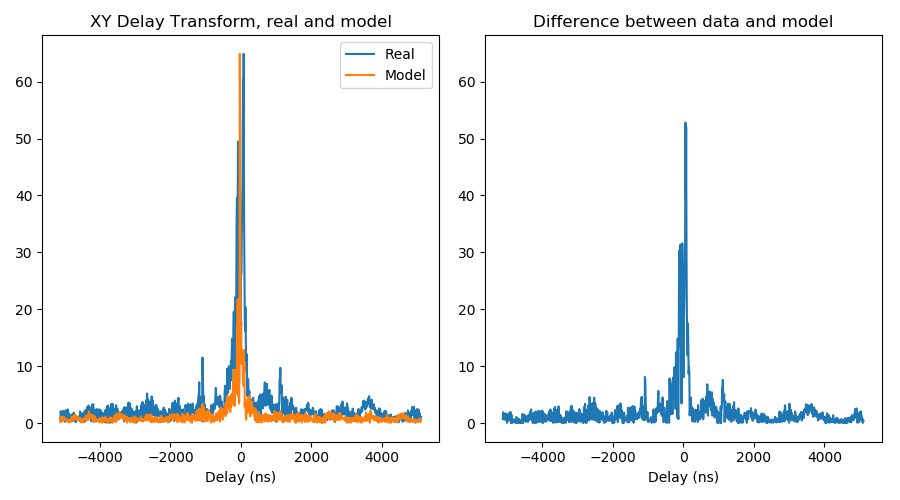

In [918]:
#Plot
amp_factor = model_max / real_max
print 'Antenna', antenna1, 'and', antenna2
print 'Amplitude correction factor:', amp_factor

#Plot delay transforms
fig = plt.figure(figsize=(9,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2, sharey = ax1, sharex = ax1)

plt.subplot(ax1)
plt.plot((delays_t),np.abs(vis_avg_delay_t), label='Real')
plt.plot((delays_xy),np.abs(vis_avg_delay_xy)/amp_factor, label='Model')
plt.xlabel('Delay (ns)')
#plt.xlim(-4500,4500) # zoom-in
plt.legend()
plt.title('XY Delay Transform, real and model')


plt.subplot(ax2)
plt.plot(delays_t, np.abs(np.abs((vis_avg_delay_t))-np.abs((vis_avg_delay_xy))/amp_factor))
plt.xlabel('Delay (ns)')
plt.title('Difference between data and model')
#plt.ylim(-65,1500)

plt.tight_layout()


<IPython.core.display.Javascript object>


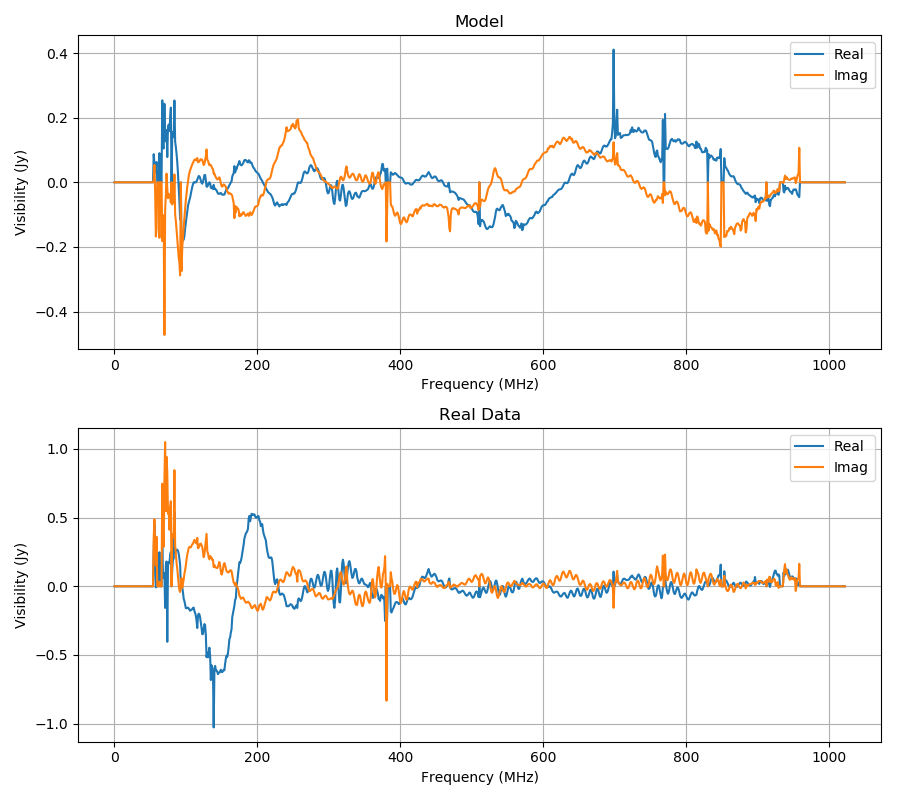

In [919]:
#Plot visibility spectrums

fig = plt.figure(figsize=(9,8))

#axm = fig.add_subplot(2,1,1)
#axr = fig.add_subplot(2,1,2, sharey = axm, sharex = axm)

plt.subplot(211)#(axm)
plt.plot(np.mean(model,axis=0).real/amp_factor,label='Real')
plt.plot(np.mean(model,axis=0).imag/amp_factor, label='Imag')
plt.legend()
plt.grid()
plt.ylabel('Visibility (Jy)')
plt.xlabel('Frequency (MHz)')
plt.title('Model')

plt.subplot(212)#(axr)
plt.plot(np.mean(data_array,axis=0).real, label='Real')
plt.plot(np.mean(data_array,axis=0).imag, label='Imag')
plt.legend()
plt.grid()
plt.ylabel('Visibility (Jy)')
plt.xlabel('Frequency (MHz)')
plt.title('Real Data')

plt.tight_layout()

In [920]:
"""
Ultimate, primary goal of notebook:
[ ] Create a working model of the delay spectrum

Smaller, more reasonable goals: 
[ ] Check if I am even using the correct files to build this
    [ ] ie, can I actually use the combined files as they are formatted currently?
[ ] Understand what size the arrays need to be and why
[ ] Verify I am reading in the data array correctly
[ ] Verify I am making the amplitude arrays correctly
[ ] Verify the tau variables are being created correctly
[ ] Comment every step

"""

'\nUltimate, primary goal of notebook:\n[ ] Create a working model of the delay spectrum\n\nSmaller, more reasonable goals: \n[ ] Check if I am even using the correct files to build this\n    [ ] ie, can I actually use the combined files as they are formatted currently?\n[ ] Understand what size the arrays need to be and why\n[ ] Verify I am reading in the data array correctly\n[ ] Verify I am making the amplitude arrays correctly\n[ ] Verify the tau variables are being created correctly\n[ ] Comment every step\n\n'